## Imports

In [1]:
import os
import math
import obspy
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from earthquake import earthquake
import util


## Get set up
Set path to data, and read eq_list (all folders in root folder)

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m5/'

eq_list = os.listdir(root)

Open catalog of events

In [3]:
client = Client("IRIS")
# cat = client.get_events(starttime=UTCDateTime("2019-01-01"), endtime=UTCDateTime("2020-01-01"), minmagnitude=5, includearrivals=True)
cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m5_catalog.xml')

Not all events had suitable data, look through all events and make a list of ones which have data (eq_with_data)

In [4]:
eq_with_data = []
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files'):
        eq_with_data.append(eq_name)

## the action!!
For all events with data, load the data and then create an earthquake object. work out tp_max and tc, and add to lists (for plotting)

In [5]:
list_tpmax = []
list_mags = []
list_tc= []
eqs = {}
count = 0
for eq_name in eq_with_data:
    
    d = util.filenameToDate(eq_name)
    
    filter_start = str(UTCDateTime(d-timedelta(seconds=1)))
    filter_stop = str(UTCDateTime(d+timedelta(seconds=1)))
    
    event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
    # print(event)
    data = obspy.read(root+eq_name+'/data/*/*')
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    try:
        data.remove_response(inv)
    except:
        continue
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    obj_name = eq_name[0:-2]
    
    eqs[obj_name] = earthquake(eq_name, event, data, picks, sensor_types = [])
    eqs[obj_name].calc_Tpmax()
    eqs[obj_name].calc_Tc()
    list_tpmax.append(eqs[obj_name]._cached_params["tau_p_max"])
    list_tc.append(eqs[obj_name]._cached_params["tau_c"])
    list_mags.append(eqs[obj_name].event.magnitudes[0].mag)
    print('earthquake number ' + str(count) + ' of '+ str(len(eq_with_data)) + ' done. It was ' + eq_name)
    count += 1

earthquake number 0 of 240 done. It was 20190628_083042.a
earthquake number 1 of 240 done. It was 20190626_052350.a
earthquake number 2 of 240 done. It was 20190623_035302.a
earthquake number 3 of 240 done. It was 20190614_001912.a
earthquake number 4 of 240 done. It was 20190613_225010.a
earthquake number 5 of 240 done. It was 20190610_144308.a
earthquake number 6 of 240 done. It was 20190607_145733.a
earthquake number 7 of 240 done. It was 20190605_161942.a
earthquake number 8 of 240 done. It was 20190604_094618.a
earthquake number 9 of 240 done. It was 20190603_084217.a
earthquake number 10 of 240 done. It was 20190601_070028.a
earthquake number 11 of 240 done. It was 20190601_042619.a
earthquake number 12 of 240 done. It was 20190530_090328.a
earthquake number 13 of 240 done. It was 20190527_101420.a
earthquake number 14 of 240 done. It was 20190527_095221.a
earthquake number 15 of 240 done. It was 20190520_111832.a
earthquake number 16 of 240 done. It was 20190517_223747.a
earthqu

earthquake number 139 of 240 done. It was 20191109_083252.a
earthquake number 140 of 240 done. It was 20191108_055206.a
earthquake number 141 of 240 done. It was 20191107_214844.a
earthquake number 142 of 240 done. It was 20191104_215325.a
earthquake number 143 of 240 done. It was 20191104_130339.a
earthquake number 144 of 240 done. It was 20191103_080610.a
earthquake number 145 of 240 done. It was 20191101_152412.a
earthquake number 146 of 240 done. It was 20191031_011119.a
earthquake number 147 of 240 done. It was 20191029_212207.a
earthquake number 148 of 240 done. It was 20191029_084603.a
earthquake number 149 of 240 done. It was 20191029_083312.a
earthquake number 150 of 240 done. It was 20191029_024238.a
earthquake number 151 of 240 done. It was 20191029_022234.a
earthquake number 152 of 240 done. It was 20191029_012803.a
earthquake number 153 of 240 done. It was 20191029_010443.a
earthquake number 154 of 240 done. It was 20191027_052948.a
earthquake number 155 of 240 done. It wa

## plotting
### tp and tc subplots
exclude points more than 1 std from the mean at each station. plot individual stations and the median of each station. 

make plot log-log

set up function for scipy line fitting

In [6]:
def model_function(x_data, a, b):
    return 10**(a*x_data + b)

Text(0.5, 0.98, 'median = triangle')

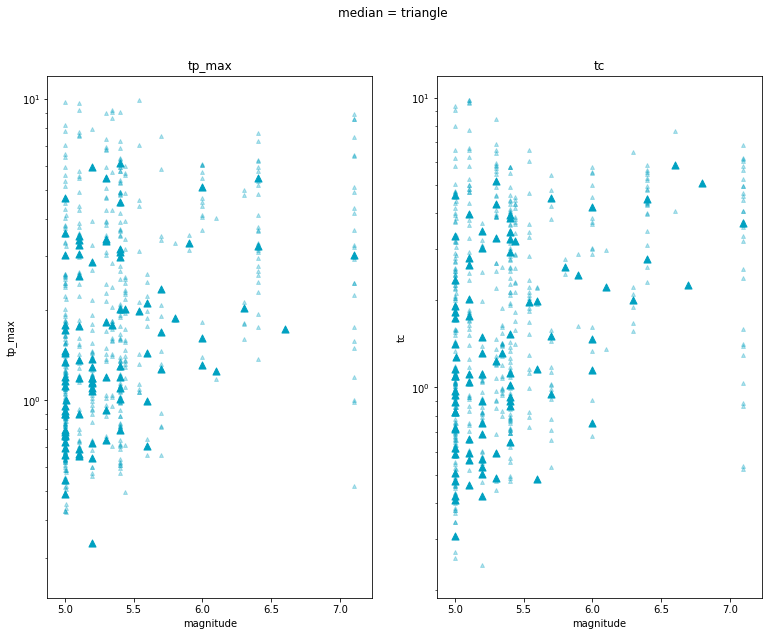

In [73]:
cs = ['#00a1c1']
fig, axs = plt.subplots(1,2, figsize=(12.8,9.6))
y_aves = []
x_aves = []

for i  in range(0, len(list_mags)):  
    mean_tp = np.mean(list_tpmax[i]) 
    std_tp = np.std(list_tpmax[i]) 
    y_tp = [] 
    for j in list_tpmax[i]: 
        if j > mean_tp-std_tp and j < mean_tp + std_tp and j < 10: 
            y_tp.append(j) 
    x_tp = np.zeros(len(y_tp))  
    x_tp = x_tp + list_mags[i]  

    mean_tc = np.mean(list_tc[i]) 
    std_tc = np.std(list_tc[i]) 
    y_tc = [] 
    for k in list_tc[i]: 
        if k > mean_tc-std_tc and k < mean_tc + std_tc and k < 10: 
            y_tc.append(k) 
    x_tc = np.zeros(len(y_tc))  
    x_tc = x_tc + list_mags[i]
    c = 0
    if len(x_tp)>0 or len(x_tc)>0:
        axs[0].scatter(x_tp, y_tp, s = 15, alpha = 0.3, c = cs[c], marker = '^', zorder =3) 
        #axs[0].scatter(list_mags[i], np.mean(y_tp), s = 50, c = cs[c], marker = 'o')
        axs[0].scatter(list_mags[i], np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =4)
        axs[1].scatter(x_tc, y_tc, s = 15, alpha = 0.3, c = cs[c], marker = '^', zorder =3) 
        axs[1].scatter(list_mags[i], np.median(y_tc), s = 50, c = cs[c], marker = '^', zorder =4)
        #axs[1].scatter(list_mags[i], np.mean(y_tc), s = 50, c = cs[c], marker = 'o')
        #FOR CURVE FITTING
        if math.isnan(np.median(y_tp))==False:
            y_aves.append(np.median(y_tp))
            x_aves.append(list_mags[i])

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_xlabel("magnitude") 
axs[1].set_xlabel("magnitude") 
axs[0].set_ylabel("tp_max") 
axs[1].set_ylabel("tc")
axs[0].set_title("tp_max") 
axs[1].set_title("tc") 
fig.suptitle("median = triangle")

add line of best fit from olsen and allen 2005, with 2x absolute deviation band

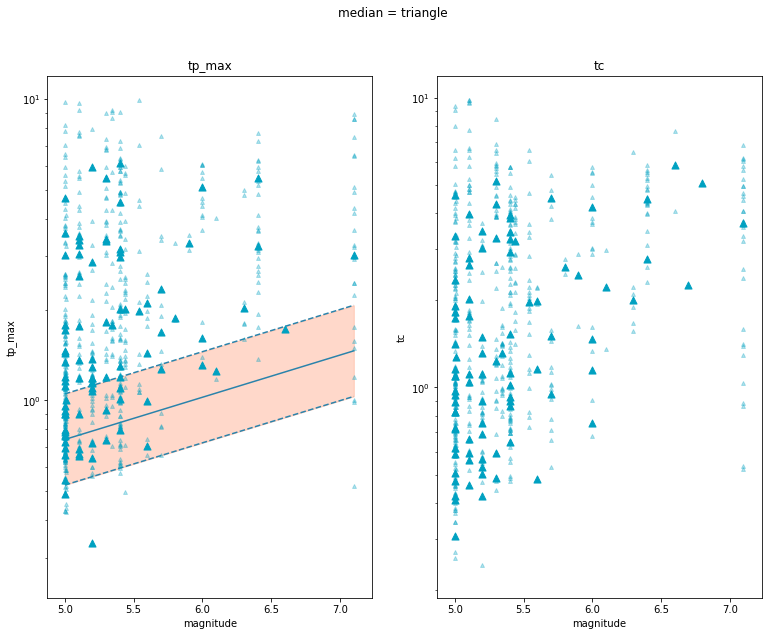

In [74]:
#plot line of best fit from olsen and allen 2005
x = np.arange(5, 7.2, 0.1)
x_lower = x - 0.54*2
x_upper =  x + 0.54*2
y = 10**(0.14*x-0.83)
y_lower = 10**(0.14*x_lower-0.83)
y_upper = 10**(0.14*x_upper-0.83)
axs[0].plot(x, y, color = '#2a83ab', zorder =2)
axs[0].fill_between(x, y_lower, y_upper, alpha = 0.3, color='coral', zorder =1)
axs[0].plot(x, y_lower, color = '#2a83ab', linestyle = '--', zorder =2)
axs[0].plot(x, y_upper, color = '#2a83ab', linestyle = '--', zorder =2)
fig

use scipy curve_fit to add my own line of best fit

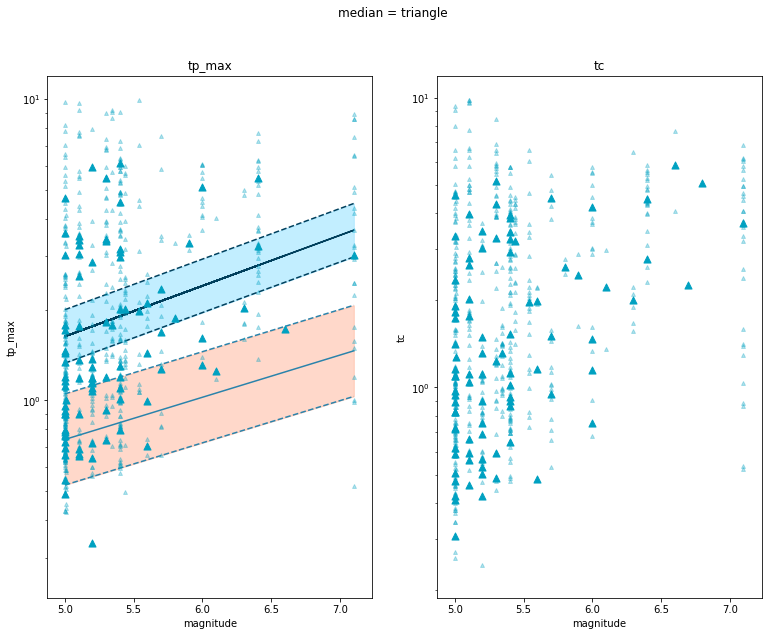

In [72]:
# plot my own line of best fit
popt, pcov = curve_fit(model_function, x_aves, y_aves)
axs[0].plot(np.array(x_aves), model_function(np.array(x_aves), *popt), color='#003f5c', zorder =2)

# add 2 * std banding

perr = np.sqrt(np.diag(pcov))
x_me = np.arange(5, 7.2, 0.1)
x_lower_me = x_me - 0.2642707*2
x_upper_me =  x_me + 0.2642707*2
y_me = 10**(0.14*x-0.83)
y_lower_me = 10**(0.14*x_lower-0.83)
y_upper_me = 10**(0.14*x_upper-0.83)
#axs[0].plot(x, y_me, color = '')
axs[0].fill_between(x, model_function(np.array(x_lower_me), *popt), model_function(np.array(x_upper_me), *popt), color = '#8adfff', alpha = 0.3, zorder =1)
axs[0].plot(x, model_function(np.array(x_lower_me), *popt), color = '#003f5c', linestyle = '--', zorder =2)
axs[0].plot(x, model_function(np.array(x_upper_me), *popt), color = '#003f5c', linestyle = '--', zorder =2)

fig # show updated figure

In [75]:
#%%script false --no-raise-error
fig.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_and_tc/2019_m5_plus_REMOVED_INSTRUMENT_RESPONSE_tp_and_tc_with_me_and_olsen_fit_shading_transparent.png', transparent=True)

### importance of filtering
turns out i only highpass filter if have acceleration data, so don't need this...

In [10]:
%%script false --no-raise-error
list_tpmax_2 = []
list_mags_2 = []
list_tc_2= []
eqs_2 = {}
count = 0
for eq_name in eq_with_data:
    
    d = util.filenameToDate(eq_name)
    
    filter_start = str(UTCDateTime(d-timedelta(seconds=1)))
    filter_stop = str(UTCDateTime(d+timedelta(seconds=1)))
    
    event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
    # print(event)
    data = obspy.read(root+eq_name+'/data/*/*')
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    obj_name = eq_name[0:-2]
    eqs_2[obj_name] = earthquake(eq_name, event, data, picks, sensor_types = [])
    eqs_2[obj_name].calc_Tpmax(freq_cut_off=0.01, filter_corners = 4)
    eqs_2[obj_name].calc_Tc()
    list_tpmax_2.append(eqs[obj_name]._cached_params["tau_p_max"])
    list_tc_2.append(eqs[obj_name]._cached_params["tau_c"])
    list_mags_2.append(eqs[obj_name].event.magnitudes[0].mag)
    print('earthquake number ' + str(count) + ' done. It was ' + eq_name)
    count += 1

In [11]:
%%script false --no-raise-error
cs = ['#000000']
fig, axs = plt.subplots(1,2, figsize=(12.8,9.6))
y_aves = []
x_aves = []
y_aves_2 = []
x_aves_2 = []
for i  in range(0, len(list_mags)):  
    mean_tp = np.mean(list_tpmax[i]) 
    std_tp = np.std(list_tpmax[i]) 
    y_tp = [] 
    for j in list_tpmax[i]: 
        if j > mean_tp-std_tp and j < mean_tp + std_tp and j < 10: 
            y_tp.append(j) 
    x_tp = np.zeros(len(y_tp))  
    x_tp = x_tp + list_mags[i]  

    mean_tp_2 = np.mean(list_tpmax_2[i]) 
    std_tp_2 = np.std(list_tpmax_2[i]) 
    y_tp_2 = [] 
    for j in list_tpmax_2[i]: 
        if j > mean_tp_2-std_tp_2 and j < mean_tp_2 + std_tp_2 and j < 10: 
            y_tp_2.append(j) 
    x_tp_2 = np.zeros(len(y_tp))  
    x_tp_2 = x_tp_2 + list_mags_2[i] 
    c = 0
    if len(x_tp)>0 or len(x_tp_2)>0:
        axs[0].scatter(x_tp, y_tp, s = 15, alpha = 0.2, c = cs[c], marker = '^') 
        #axs[0].scatter(list_mags[i], np.mean(y_tp), s = 50, c = cs[c], marker = 'o')
        axs[0].scatter(list_mags[i], np.median(y_tp), s = 50, c = cs[c], marker = '^')
        axs[1].scatter(x_tp_2, y_tp_2, s = 15, alpha = 0.2, c = cs[c], marker = '^') 
        axs[1].scatter(list_mags_2[i], np.median(y_tp_2), s = 50, c = cs[c], marker = '^')
        #axs[1].scatter(list_mags[i], np.mean(y_tc), s = 50, c = cs[c], marker = 'o')
        #FOR CURVE FITTING
        if math.isnan(np.median(y_tp))==False:
            y_aves.append(np.median(y_tp))
            x_aves.append(list_mags[i])
        if math.isnan(np.median(y_tp_2))==False:
            y_aves_2.append(np.median(y_tp_2))
            x_aves_2.append(list_mags_2[i])

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_xlabel("magnitude") 
axs[1].set_xlabel("magnitude") 
axs[0].set_ylabel("tp_max") 
axs[1].set_ylabel("tc")
axs[0].set_title("tp_max") 
axs[1].set_title("tc") 
fig.suptitle("median = triangle")

add line of best fit from olsen and allen 2005, with 2x absolute deviation band

In [12]:
%%script false --no-raise-error
#plot line of best fit from olsen and allen 2005
x = np.arange(5, 7.2, 0.1)
x_lower = x - 0.54*2
x_upper =  x + 0.54*2
y = 10**(0.14*x-0.83)
y_lower = 10**(0.14*x_lower-0.83)
y_upper = 10**(0.14*x_upper-0.83)
axs[0].plot(x, y, color = 'red')
axs[0].plot(x, y_lower, color = 'red', linestyle = '--')
axs[0].plot(x, y_upper, color = 'red', linestyle = '--')
fig

use scipy curve_fit to add my own line of best fit

In [13]:
%%script false --no-raise-error
# plot my own line of best fit
popt, pcov = curve_fit(model_function, x_aves, y_aves)
axs[0].plot(np.array(x_aves), model_function(np.array(x_aves), *popt), color='blue')

# add 2 * std banding

perr = np.sqrt(np.diag(pcov))
x_me = np.arange(5, 7.2, 0.1)
x_lower_me = x_me - 0.2642707*2
x_upper_me =  x_me + 0.2642707*2
y_me = 10**(0.14*x-0.83)
y_lower_me = 10**(0.14*x_lower-0.83)
y_upper_me = 10**(0.14*x_upper-0.83)
axs[0].plot(x, y_me, color = 'red')
axs[0].plot(x, model_function(np.array(x_lower_me), *popt), color = 'blue', linestyle = '--')
axs[0].plot(x, model_function(np.array(x_upper_me), *popt), color = 'blue', linestyle = '--')

fig # show updated figure

In [14]:
%%script false --no-raise-error
# plot my own line of best fit
popt_2, pcov_2 = curve_fit(model_function, x_aves_2, y_aves_2)
axs[1].plot(np.array(x_aves_2), model_function(np.array(x_aves_2), *popt_2), color='green')

# add 2 * std banding

perr_2 = np.sqrt(np.diag(pcov_2))
x_me_2 = np.arange(5, 7.2, 0.1)
x_lower_me_2 = x_me_2 - 0.2642707*2
x_upper_me_2 =  x_me_2 + 0.2642707*2
y_me_2 = 10**(0.14*x-0.83)
y_lower_me_2 = 10**(0.14*x_lower-0.83)
y_upper_me_2 = 10**(0.14*x_upper-0.83)
axs[1].plot(x_me_2, y_me_2, color = 'red')
axs[1].plot(x_me_2, model_function(np.array(x_lower_me_2), *popt_2), color = 'green', linestyle = '--')
axs[1].plot(x_me_2, model_function(np.array(x_upper_me_2), *popt_2), color = 'green', linestyle = '--')

fig # show updated figure